# Step 0: Install the Required Libraries

create the conda environment using the env.yml file

In [ ]:
# %pip install 'smolagents[telemetry]'
# %pip install opentelemetry-sdk opentelemetry-exporter-otlp openinference-instrumentation-smolagents
# %pip install langfuse datasets 'smolagents[gradio]' gradio
# pip install google-genai google-auth smolagents[litellm]

# Step 1: Instrument Your Agent

create a .env file in this directory that looks like the .env-example file using your API keys

In [1]:
import os
import base64
from dotenv import load_dotenv

load_dotenv()  # Loads variables from .env

LANGFUSE_AUTH = base64.b64encode(
    f"{os.environ.get('LANGFUSE_PUBLIC_KEY')}:{os.environ.get('LANGFUSE_SECRET_KEY')}".encode()
).decode()

os.environ["OTEL_EXPORTER_OTLP_ENDPOINT"] = os.environ.get("LANGFUSE_HOST") + "/api/public/otel"
os.environ["OTEL_EXPORTER_OTLP_HEADERS"] = f"Authorization=Basic {LANGFUSE_AUTH}"

### Test Google Gemini LLM connection, will use for LLM-as-a-judge

In [3]:
use_google = True
from google import genai

client = genai.Client(api_key=os.environ.get("GEMINI_API_KEY"))

response = client.models.generate_content(
    model="gemini-2.0-flash",
    contents="1+1",
)

print(response.text)

2



In [7]:
from opentelemetry.sdk.trace import TracerProvider
from openinference.instrumentation.smolagents import SmolagentsInstrumentor
from opentelemetry.exporter.otlp.proto.http.trace_exporter import OTLPSpanExporter
from opentelemetry.sdk.trace.export import SimpleSpanProcessor

# Create a TracerProvider for OpenTelemetry
trace_provider = TracerProvider()

# Add a SimpleSpanProcessor with the OTLPSpanExporter to send traces
trace_provider.add_span_processor(SimpleSpanProcessor(OTLPSpanExporter()))

# Set the global default tracer provider
from opentelemetry import trace
trace.set_tracer_provider(trace_provider)
tracer = trace.get_tracer(__name__)

# Instrument smolagents with the configured provider
SmolagentsInstrumentor().instrument(tracer_provider=trace_provider)

# Step 2: Test Your Instrumentation

In [16]:
from smolagents import HfApiModel, CodeAgent, LiteLLMModel

if use_google:
    model = LiteLLMModel(
    model_id="gemini/gemini-2.0-flash", # you can see other model names here: https://cloud.google.com/vertex-ai/generative-ai/docs/learn/models. It is important to prefix the name with "gemini/"
    api_key=os.getenv("GEMINI_API_KEY"),
    max_tokens=8192
)
else:
    model = HfApiModel()

# Create a simple agent to test instrumentation
agent = CodeAgent(
    tools=[],
    model=model
)

agent.run("1+1=")

╭──────────────────────────────────────────────────── New run ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 1+1=                                                                                                            │
│                                                                                                                 │
╰─ LiteLLMModel - gemini/gemini-2.0-flash ────────────────────────────────────────────────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  result = 1 + 1                                                                                                   
  final_answer(answer=result)                                                                                      
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Out - Final answer: 2

[Step 1: Duration 1.57 seconds| Input tokens: 2,173 | Output tokens: 50]

2

# Step 3: Observe and Evaluate a More Complex Agent

In [5]:
from smolagents import DuckDuckGoSearchTool

search_tool = DuckDuckGoSearchTool()
agent = CodeAgent(tools=[search_tool], model=model)

agent.run("How many Rubik's Cubes could you fit inside the Notre Dame Cathedral?")

╭──────────────────────────────────────────────────── New run ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ How many Rubik's Cubes could you fit inside the Notre Dame Cathedral?                                           │
│                                                                                                                 │
╰─ LiteLLMModel - gemini/gemini-2.0-flash ────────────────────────────────────────────────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  cathedral_search = web_search(query="volume of Notre Dame Cathedral")                                            
  print(cathedral_search)                                                                                          
  cube_search = web_search(query="Rubik's Cube dimensions")                                                        
  print(cube_search)                                                                                               
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Execution logs:
## Search Results

[List of largest church buildings - Wikipedia](https://en.wikipedia.org/wiki/List_of_largest_church_buildings)
Tallest and largest (by volume) Orthodox church building in the world. [30] [31] Basilica-Cathedral of Our Lady of 
the Pillar: 8,318 [32] ... The longest Gothic cathedral in Europe [66] Notre Dame de Paris: 4,800 [citation needed]
5,500 9,000 1163-1345; 2019-present (reconstruction)

[Notre-Dame de Paris - Wikipedia](https://en.wikipedia.org/wiki/Notre-Dame_de_Paris)
Notre-Dame de Paris (French: Cathédrale Notre-Dame de Paris French: [nɔtʁ(ə) dam də paʁi] ⓘ; meaning "Cathedral of 
Our Lady of Paris"), often referred to simply as Notre-Dame, [a] [b] is a medieval Catholic cathedral on the Île de
la Cité (an island in the River Seine), in the 4th arrondissement of Paris, France.It is the cathedral church of 
the Roman Catholic Archdiocese of Paris.

[Plans and Elevations - Notre-Dame de Paris](https://www.notredamedeparis.fr/en/understand/architecture/plans/)
Like most French cathedrals, Notre-Dame de Paris follows a Latin cross plan. Its main façade is oriented 
west-northwest, and its apse is oriented east-southeast. The cathedral can accommodate up to 9,000 people, 
including 1,500 in the galleries. Main Dimensions of the Cathedral. Overall area: over 6,000 m²; Length: 127 m; 
Width: 48 m

[Interior Architecture - Notre-Dame de 
Paris](https://www.notredamedeparis.fr/en/understand/architecture/interior-architecture/)
Notre-Dame de Paris is characterized by a double row of columns forming the aisles. During an enlargement of the 
building in the 13th century, chapels were placed around the aisles. ... This volume is proportional to the 
dimensions of the cathedral. Liturgical celebrations take place in this space. The two arms of the transept are 
also called ...

[The Majestic Layout of Notre-Dame - Friends of Notre-Dame de 
Paris](https://www.friendsofnotredamedeparis.org/notre-dame-cathedral/architecture/layout/)
Like most French cathedrals, Notre-Dame de Paris draws a plan in the shape of a Latin cross. Its main facade is 
oriented west-north-west, and the apse is oriented east-south-east. The cathedral can hold up to 9,000 people, 
including 1,500 in the stands. Notre Dame floor plans Notre Dame floor plans Notre-Dame Cathedral Dimensions

[Notre-Dame de Paris - official website](https://www.notredamedeparis.fr/en/)
"Notre Dame, Queen of Peace… from the Magnificat to the Apocalypse" For the first time since the 2019 fire, the 
traditional Lenten conferences are once again being held (in French) at Notre-Dame de Paris. This year, they will 
highlight the role of the Virgin Mary, Queen of Peace, in God's plan of salvation. Drawing from […]

[How Big Is The Notre Dame Cathedral - 
Christian.net](https://christian.net/arts-and-culture/how-big-is-the-notre-dame-cathedral/)
The Notre Dame Cathedral's exterior is graced with a network of flying buttresses, an architectural innovation that
allowed for the construction of soaring, open interiors and expansive stained glass windows. ... Interior Volume. 
The voluminous interior of the Notre Dame Cathedral encompasses a space that resonates with the echoes of centuries
...

[Figures and facts about Notre Dame Cathedral in Paris](https://www.eutouring.com/facts_notre_dame_cathedral.html)
* Notre Dame has a total surface area of 4,800 metres squared, the Notre Dame Cathedral in Paris is very impressive
and has a length of 128m and the height of the spire is 96 metres. * The width of the choir is 12m and the length 
is 36m, and the width of the nave is also 12m, however the height of the nave is a very impressive 60 metres.

[Notre Dame Cathedral - Data, Photos & Plans - 
WikiArquitectura](https://en.wikiarquitectura.com/building/Notre-Dame-Cathedral/)
The cathedral underwent many changes and restorations, the most significant undertaken in 1844 by Viollet-le-Duc 
and Baptiste Lassus, which lasted 23 years. More recently, in 1965, excavation

[Step 1: Duration 3.75 seconds| Input tokens: 2,249 | Output tokens: 119]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 2 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  cathedral_volume_m3 = 6900                                                                                       
  cathedral_volume_cm3 = cathedral_volume_m3 * (100**3)  # Convert m^3 to cm^3                                     
  print(f"{cathedral_volume_cm3=}")                                                                                
                                                                                                                   
  cube_side_cm = 5.75                                                                                              
  cube_volume_cm3 = cube_side_cm**3                                                                                
  print(f"{cube_volume_cm3=}")                                                                                     
                                                                                                                   
  num_cubes = cathedral_volume_cm3 / cube_volume_cm3                                                               
  print(f"{num_cubes=}")                                                                                           
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Execution logs:
cathedral_volume_cm3=6900000000
cube_volume_cm3=190.109375
num_cubes=36294896.03024574

Out: None

[Step 2: Duration 1.94 seconds| Input tokens: 7,101 | Output tokens: 399]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 3 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  final_answer("Approximately 36.3 million")                                                                       
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Out - Final answer: Approximately 36.3 million

[Step 3: Duration 0.82 seconds| Input tokens: 12,494 | Output tokens: 453]

'Approximately 36.3 million'

## [Trace](https://us.cloud.langfuse.com/project/cm8p07ra800wvad07nhjyaa55/traces/85838359b2036e9fa9b2eec31c602f4f?timestamp=2025-03-25T23:30:04.332Z&display=details)

### Trace with tags, user and session id

In [8]:
from opentelemetry import trace

search_tool = DuckDuckGoSearchTool()
agent = CodeAgent(
    tools=[search_tool],
    model=model
)

with tracer.start_as_current_span("Smolagent-Trace") as span:
    span.set_attribute("langfuse.user.id", "smolagent-user-123")
    span.set_attribute("langfuse.session.id", "smolagent-session-123456789")
    span.set_attribute("langfuse.tags", ["city-question", "testing-agents"])

    agent.run("What is the capital of Germany?")

╭──────────────────────────────────────────────────── New run ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ What is the capital of Germany?                                                                                 │
│                                                                                                                 │
╰─ LiteLLMModel - gemini/gemini-2.0-flash ────────────────────────────────────────────────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  capital = web_search(query="capital of Germany")                                                                 
  print(capital)                                                                                                   
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Execution logs:
## Search Results

[Capital of Germany - Wikipedia](https://en.wikipedia.org/wiki/Capital_of_Germany)
Learn about the history and current status of Berlin as the capital of Germany. Find out how Berlin became the seat
of the Federal President, the Federal Council and most of the ministries, and how Bonn still hosts some federal 
offices.

[Berlin - Wikipedia](https://en.wikipedia.org/wiki/Berlin)
Berlin (/ bɜːrˈlɪn / bur-LIN; German: [bɛʁˈliːn] ⓘ) [10] is the capital and largest city of Germany, by both area 
and population. [11] With 3.66 million inhabitants, [5] it has the highest population within its city limits of any
city in the European Union.

[Berlin | History, Map, Population, Attractions, & Facts | Britannica](https://www.britannica.com/place/Berlin)
Berlin is the capital and chief urban center of Germany. The city lies at the heart of the North German Plain, 
athwart an east-west commercial and geographic axis that helped make it the capital of the kingdom of Prussia and 
then, from 1871, of a unified Germany.

[Berlin - Simple English Wikipedia, the free encyclopedia](https://simple.wikipedia.org/wiki/Berlin)
Berlin is the capital city of Germany and the largest city in the European Union. It has a rich history, a diverse 
culture, and many famous landmarks and attractions.

[What are the two capitals of Germany? - 
NCESC](https://www.ncesc.com/geographic-faq/what-are-the-two-capitals-of-germany/)
Learn about the history and current status of the two capitals of Germany: Berlin, the official capital, and Bonn, 
the seat of government. Find out why Germany has two capitals, how they changed over time, and which other 
countries have multiple capitals.

[What is the Capital of Germany? - Mappr](https://www.mappr.co/capital-cities/germany/)
Learn about Berlin, the capital of Germany, and its rich and turbulent history, diverse culture, and vibrant 
economy. Find out where Berlin is located, how it became the capital, and what attractions it offers.

[Germany's Capital Moves From Bonn to Berlin - 
ThoughtCo](https://www.thoughtco.com/germany-capital-from-bonn-to-berlin-1434930)
Learn how Germany decided to unify and move its capital from Bonn to Berlin after the fall of the Berlin Wall in 
1989. Find out why Bonn still remains the second capital and the challenges of having two capital cities.

[What Is The Capital Of Germany? - 
WorldAtlas](https://www.worldatlas.com/articles/what-is-the-capital-of-germany.html)
Learn about the history, geography, and attractions of Berlin, the largest and most populous city in Germany. Find 
out how Berlin became the capital of Germany after the reunification of East and West Germany in 1990.

[Berlin - Wikiwand](https://www.wikiwand.com/en/articles/Berlin)
Berlin (/ bɜːrˈlɪn / bur-LIN; German: [bɛʁˈliːn] ⓘ) is the capital and largest city of Germany, by both area and 
population. With 3.66 million inhabitants, it has the highest population within its city limits of any city in the 
European Union. The city is also one of the states of Germany, being the third smallest state in the country by 
area. Berlin is surrounded by the state of ...

[Capital of Germany - Wikiwand](https://www.wikiwand.com/en/articles/Capital_of_Germany)
The capital of Germany is the City Land of Berlin. It is the seat of the Federal President of Germany, whose 
official residence is Bellevue Castle. The Federal Council is the representation of the Lands of Germany and has 
its seat at the former Prussian House of Lords. Though most of the ministries are seated in Berlin, some of them, 
as well as some minor departments, are seated in Bonn, the ...

Out: None

[Step 1: Duration 2.63 seconds| Input tokens: 2,240 | Output tokens: 45]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 2 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  final_answer("Berlin")                                                                                           
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Out - Final answer: Berlin

[Step 2: Duration 1.41 seconds| Input tokens: 5,503 | Output tokens: 75]

## [Trace](https://us.cloud.langfuse.com/project/cm8p07ra800wvad07nhjyaa55/traces/8601410ec6e4a46505fd03ee5a083e21?timestamp=2025-03-25T23:35:12.019Z&display=details)

In [ ]:
import gradio as gr
from opentelemetry.trace import format_trace_id
from smolagents import (CodeAgent, HfApiModel)
from langfuse import Langfuse

langfuse = Langfuse()
agent = CodeAgent(tools=[], model=model, add_base_tools=True)

formatted_trace_id = None  # We'll store the current trace_id globally for demonstration

def respond(prompt, history):
    with trace.get_tracer(__name__).start_as_current_span("Smolagent-Trace") as span:
        output = agent.run(prompt)

        current_span = trace.get_current_span()
        span_context = current_span.get_span_context()
        trace_id = span_context.trace_id
        global formatted_trace_id
        formatted_trace_id = str(format_trace_id(trace_id))
        langfuse.trace(id=formatted_trace_id, input=prompt, output=output)

    history.append({"role": "assistant", "content": str(output)})
    return history

def handle_like(data: gr.LikeData):
    # For demonstration, we map user feedback to a 1 (like) or 0 (dislike)
    if data.liked:
        langfuse.score(
            value=1,
            name="user-feedback",
            trace_id=formatted_trace_id
        )
    else:
        langfuse.score(
            value=0,
            name="user-feedback",
            trace_id=formatted_trace_id
        )

with gr.Blocks() as demo:
    chatbot = gr.Chatbot(label="Chat", type="messages")
    prompt_box = gr.Textbox(placeholder="Type your message...", label="Your message")

    # When the user presses 'Enter' on the prompt, we run 'respond'
    prompt_box.submit(
        fn=respond,
        inputs=[prompt_box, chatbot],
        outputs=chatbot
    )

    # When the user clicks a 'like' button on a message, we run 'handle_like'
    chatbot.like(handle_like, None, None)

demo.launch()


* Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


╭──────────────────────────────────────────────────── New run ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ when is the next full moon?                                                                                     │
│                                                                                                                 │
╰─ HfApiModel - Qwen/Qwen2.5-Coder-32B-Instruct ──────────────────────────────────────────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  full_moon_search = web_search(query="next full moon date")                                                       
  print(full_moon_search)                                                                                          
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Execution logs:
## Search Results

[2025 Full Moon calendar: When to see the Full Moon and 
phases](https://www.astronomy.com/observing/full-moon-calendar-dates-times-types/)
The next Full Moon will be the Pink Moon, which occurs at 8:22 p.m. on Saturday, April 12, 2025. ... Beaver Moon 
(November): Reflects the time when beavers are busy building their winter dams.

[Moon Phases 2025 - Lunar Calendar - timeanddate.com](https://www.timeanddate.com/moon/phases/)
Moon phases for 2025 or any year. New Moon and Full Moon calendar with precise times and simulation of the Moon 
phase today. When is the next Full Moon? Mar 29. Sign in. News. News Home; ... Mar 22, 2025 at 4:29 am (Next Phase)
Full Moon: Mar 13, 2025 at 11:54 pm (Previous Phase)

[Full moon calendar 2025: When to see the next full moon](https://www.space.com/16830-full-moon-calendar.html)
Here are the dates for the full moons in 2025. The next full moon will be on Saturday, April 12. It will officially
reach its full moon phase at 8:22 p.m. EDT (0022 GMT April 13), but local ...

[When Is the Next Full Moon 2025-2026? - Farmers' 
Almanac](https://www.farmersalmanac.com/full-moon-dates-and-times)
Find out when the next full Moon will occur and what it is called in different cultures. Learn about the lunar 
phases, supermoons, blue moons, and how the Moon affects your behavior and fishing.

[Full Moon Dates: When is the Next Full Moon? | The Old Farmer's 
Almanac](https://www.almanac.com/astronomy/moon/full)
The next full Moon will occur on April 12, 2025 (Eastern Time) or April 13, 2025 (GMT Time).The Old Farmer's 
Almanac has a unique tool that calculates your Full Moon by your zip code or postal code—for an exact day and time.
Plus, we'll tell you how to see the next full Moon at its best! Whether you're planning a full Moon activity or 
just want to sing by the light of the Moon, we've got you ...

[Full Moon 2025 - Full Moon Dates and Times - Today's Moon 
Phase](https://www.mooninfo.org/moon-phases/full-moon-2025.html)
Full Moon 2025, Next Full Moon, with dates and times for all full moons and new moons in 2025. Full Moon 2025. 
Location: Greenwich, London, United Kingdom. Latitude: 51.49336749999999. ... • Next full moon: Sunday, April 13, 
2025 - 01:23 am GMT Full moon schedule for 2025. Month. Full Moon Date. Full Moon Name. January. January 13. 10:27 
pm.

[Next full Moon calendar dates 2025](https://www.skyatnightmagazine.com/advice/next-full-moon)
Find out when the next full Moon is visible with our full Moon calendar with dates, times and names for each one 
throughout 2025.

[Full moons of 2025: When is the next full moon? | Live 
Science](https://www.livescience.com/space/the-moon/full-moons-of-2025-names-dates-and-everything-you-need-to-know)
Full moon guide: When are the full moons of 2025? Here are all of the full moon dates and times for 2025, according
to timeanddate.com, including the most commonly used names in North America ...

[Full Moons 2025 | Full Moon Calendar 2025 | Next Full Moon Schedule 
...](https://starwalk.space/en/news/full-moon-calendar-2025)
Find out the dates and times of all 12 Full Moons in 2025, including three Supermoons and two Blood Moons. Learn 
the traditional names, constellations, and celestial events for each Full Moon night.

[Moongiant > Next Full Moon](https://www.moongiant.com/)
The Next Full Moon will be on April 12, 2025 8:22pm EDT. Visit Moongiant to track the Moon Phase daily, monthly, 
yearly and always know when the next Full Moon is coming. Today's Moon Phase; ... When is the Next New Moon. New 
Moon Dark skies are the best time to stargaze!

Out: None

[Step 1: Duration 5.07 seconds| Input tokens: 2,141 | Output tokens: 65]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 2 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  final_answer("April 12, 2025")                                                                                   
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Out - Final answer: April 12, 2025

[Step 2: Duration 6.59 seconds| Input tokens: 5,500 | Output tokens: 172]

## [Trace with Score](https://us.cloud.langfuse.com/project/cm8p07ra800wvad07nhjyaa55/traces/fd148a268dd6bcb22c6de3db9e75e3ed?timestamp=2025-03-25T23%3A38%3A14.231Z&display=details&view=scores)
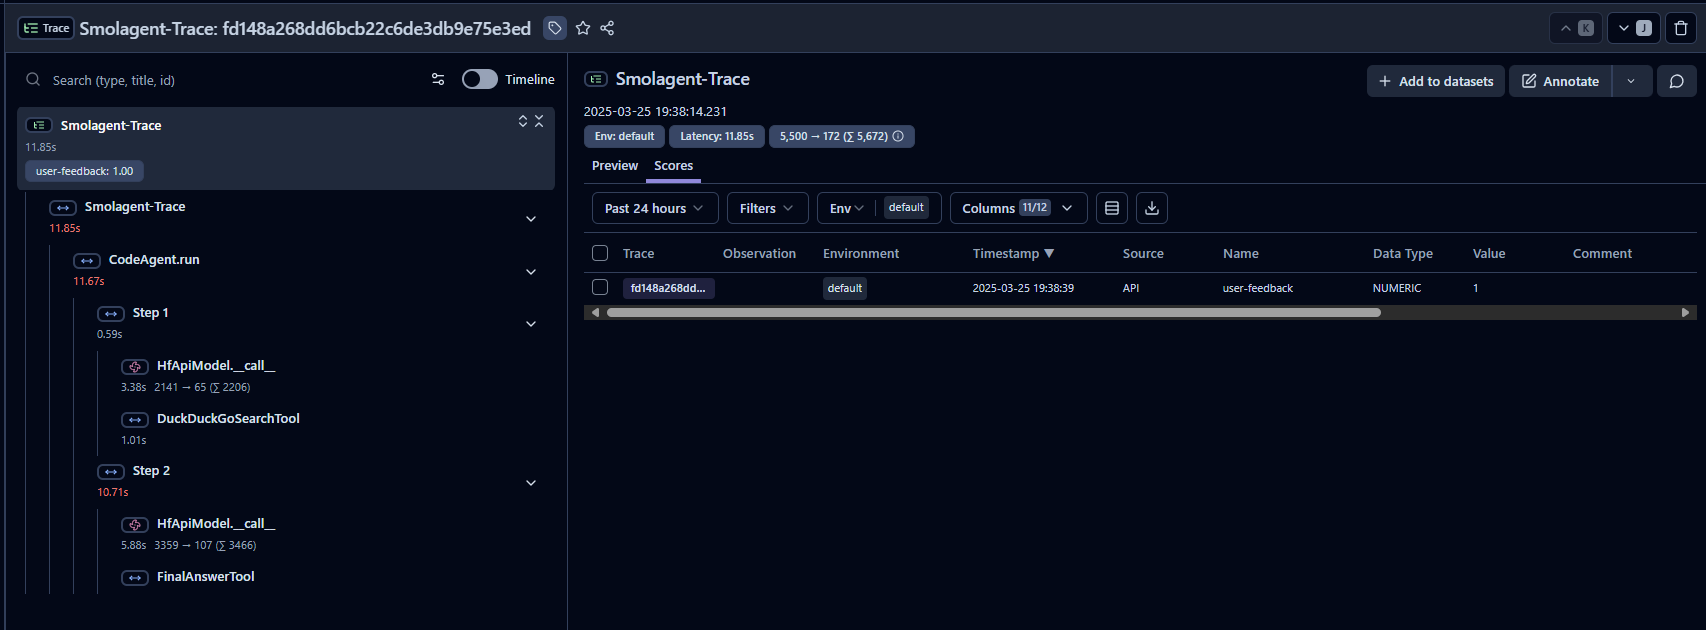

## 5. LLM-as-a-Judge

Requires LLM API
![Langfuse Evaluation Template](/home/ddd/documents/hugginface_agents_course/Langfuse_Eval_Template.png)

In [9]:
# Example: Checking if the agent’s output is toxic or not.

search_tool = DuckDuckGoSearchTool()
agent = CodeAgent(tools=[search_tool], model=model)

agent.run("Can eating carrots improve your vision?")


╭──────────────────────────────────────────────────── New run ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ Can eating carrots improve your vision?                                                                         │
│                                                                                                                 │
╰─ LiteLLMModel - gemini/gemini-2.0-flash ────────────────────────────────────────────────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  search_result = web_search(query="can eating carrots improve vision")                                            
  print(search_result)                                                                                             
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Execution logs:
## Search Results

[Carrots & Eye Health: Myth or Fact? - University of Utah 
Health](https://healthcare.utah.edu/healthfeed/2020/02/carrots-eye-health-myth-or-fact)
You've probably heard that carrots are good for your eyes, and it's true. Carrots are a super source of 
beta-carotene—and that's a start. But it takes a whole lot more to protect your irreplaceable vision.

[Fact or Fiction?: Carrots Improve Your Vision - Scientific 
American](https://www.scientificamerican.com/article/fact-or-fiction-carrots-improve-your-vision/)
Yet the question remains: Are carrots truly able to improve eyesight or is that the stuff of fiction? The answer is
yes, under certain conditions, eating carrots will help improve eyesight.

[Myth or Fact: Eating Carrots Improves Eyesight - Duke 
Health](https://www.dukehealth.org/blog/myth-or-fact-eating-carrots-improves-eyesight)
The notion that eating carrots improves eyesight sounds like a story your mother made up to get you to eat your 
vegetables. But is there truth to it?

[Are Carrots Good for Your Eyes? - Healthline](https://www.healthline.com/nutrition/are-carrots-good-for-your-eyes)
Though the idea that carrots are good for your eyesight stemmed from a myth, carrots contain many beneficial 
nutrients that may support healthy eyes and many other health benefits.

[Myths About Your Eyes and Vision - WebMD](https://www.webmd.com/eye-health/fact-fiction-myths-about-eyes)
Eating Carrots Will Improve Your Vision Fact: Carrots are high in vitamin A, a nutrient essential for good vision. 
Eating carrots will provide you with the small amount of vitamin A needed for ...

[How Eating Carrots Daily Can Improve Your Eye 
Health](https://www.verywellhealth.com/are-carrots-good-for-your-eyes-8716358)
The many nutrients in carrots make them good vegetables for eyes and vision. Research suggests carrots support and 
improve eye health, which may help prevent future vision loss or changes.

[Common Eye Health Myths: What's True & What's Not - Vision 
Center](https://www.visioncenter.org/resources/eye-health-myths/)
It's believed that eating carrots can improve your eyesight. But in reality, it won't improve visual acuity for 
people with poor vision or give them night vision.

[Does Eating Carrots Improve Your Vision? - 
Snopes.com](https://www.snopes.com/fact-check/does-eating-carrots-improve-vision/)
While carrots are a good source of vitamin A (which is important for healthy eyesight, skin, growth, and resisting 
infection), eating them won't improve vision.

[Are carrots really good for your eyes? - All About 
Vision](https://www.allaboutvision.com/eye-care/vision-health/nutrition/carrots-and-vision/)
Can carrots reverse poor eyesight? Eating a diet that's abundant in vitamin A and beta-carotene is great for your 
vision, but it can't restore eyesight to 20/20. You'll need help from prescription eyeglasses, contact lenses or 
vision surgery if you have any notable level of blurry vision.

[Will Eating Carrots Really Improve Your Eyes? - 
AARP](https://www.aarp.org/health/healthy-living/can-carrots-improve-eyes/)
Consuming sufficient amounts of vitamin A also helps with night vision and dry eye, both of which become bigger 
challenges as people get older. Your body converts beta-carotene in orange and yellow fruits and vegetables — such 
as carrots, sweet potato, cantaloupe, pumpkin and winter squash — into vitamin A.

Out: None

[Step 1: Duration 2.50 seconds| Input tokens: 2,240 | Output tokens: 60]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 2 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  final_answer("Yes, eating carrots can improve your vision under certain conditions, as they are a good source    
  of vitamin A, which is essential for good vision. However, they won't necessarily improve vision for people      
  with already good vision or reverse poor eyesight to 20/20.")                                                    
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Out - Final answer: Yes, eating carrots can improve your vision under certain conditions, as they are a good source
of vitamin A, which is essential for good vision. However, they won't necessarily improve vision for people with 
already good vision or reverse poor eyesight to 20/20.

[Step 2: Duration 2.00 seconds| Input tokens: 5,461 | Output tokens: 224]

"Yes, eating carrots can improve your vision under certain conditions, as they are a good source of vitamin A, which is essential for good vision. However, they won't necessarily improve vision for people with already good vision or reverse poor eyesight to 20/20."

# Offline Evaluation

In [10]:
import pandas as pd
from datasets import load_dataset

# Fetch GSM8K from Hugging Face
dataset = load_dataset("openai/gsm8k", 'main', split='train')
df = pd.DataFrame(dataset)
print("First few rows of GSM8K dataset:")
display(df.head())

First few rows of GSM8K dataset:


,question,answer
0,Natalia sold clips to 48 of her friends in Apr...,Natalia sold 48/2 = <<48/2=24>>24 clips in May...
1,Weng earns $12 an hour for babysitting. Yester...,Weng earns 12/60 = $<<12/60=0.2>>0.2 per minut...
2,Betty is saving money for a new wallet which c...,"In the beginning, Betty has only 100 / 2 = $<<..."
3,"Julie is reading a 120-page book. Yesterday, s...",Maila read 12 x 2 = <<12*2=24>>24 pages today....
4,James writes a 3-page letter to 2 different fr...,He writes each friend 3*2=<<3*2=6>>6 pages a w...


In [11]:
from langfuse import Langfuse
langfuse = Langfuse()

langfuse_dataset_name = "gsm8k_dataset_huggingface"

# Create a dataset in Langfuse
langfuse.create_dataset(
    name=langfuse_dataset_name,
    description="GSM8K benchmark dataset uploaded from Huggingface",
    metadata={
        "date": "2025-03-10",
        "type": "benchmark"
    }
)

Dataset(id='cm8p5g14600c0ad07dvkzhd1b', name='gsm8k_dataset_huggingface', description='GSM8K benchmark dataset uploaded from Huggingface', metadata={'date': '2025-03-10', 'type': 'benchmark'}, project_id='cm8p07ra800wvad07nhjyaa55', created_at=datetime.datetime(2025, 3, 25, 23, 51, 9, 222000, tzinfo=datetime.timezone.utc), updated_at=datetime.datetime(2025, 3, 26, 22, 56, 10, 609000, tzinfo=datetime.timezone.utc))

In [12]:
for idx, row in df.iterrows():
    langfuse.create_dataset_item(
        dataset_name=langfuse_dataset_name,
        input={"text": row["question"]},
        expected_output={"text": row["answer"]},
        metadata={"source_index": idx}
    )
    if idx >= 9: # Upload only the first 10 items for demonstration
        break

In [17]:
from opentelemetry.trace import format_trace_id
from smolagents import (CodeAgent, HfApiModel, LiteLLMModel)

# Example: using HfApiModel or LiteLLMModel to access openai, anthropic, gemini, etc. models:

agent = CodeAgent(
    tools=[],
    model=model,
    add_base_tools=True
)

def run_smolagent(question):
    with tracer.start_as_current_span("Smolagent-Trace") as span:
        span.set_attribute("langfuse.tag", "dataset-run")
        output = agent.run(question)

        current_span = trace.get_current_span()
        span_context = current_span.get_span_context()
        trace_id = span_context.trace_id
        formatted_trace_id = format_trace_id(trace_id)

        langfuse_trace = langfuse.trace(
            id=formatted_trace_id,
            input=question,
            output=output
        )
    return langfuse_trace, output

In [18]:
dataset = langfuse.get_dataset(langfuse_dataset_name)

# Run our agent against each dataset item (limited to first 10 above)
for item in dataset.items:
    langfuse_trace, output = run_smolagent(item.input["text"])

    # Link the trace to the dataset item for analysis
    item.link(
        langfuse_trace,
        run_name="smolagent-notebook-run-01",
        run_metadata={ "model": model.model_id }
    )

    # Optionally, store a quick evaluation score for demonstration
    langfuse_trace.score(
        name="<example_eval>",
        value=1,
        comment="This is a comment"
    )

# Flush data to ensure all telemetry is sent
langfuse.flush()

╭──────────────────────────────────────────────────── New run ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ Tina makes $18.00 an hour.  If she works more than 8 hours per shift, she is eligible for overtime, which is    │
│ paid by your hourly wage + 1/2 your hourly wage.  If she works 10 hours every day for 5 days, how much money    │
│ does she make?                                                                                                  │
│                                                                                                                 │
╰─ LiteLLMModel - gemini/gemini-2.0-flash ────────────────────────────────────────────────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  hourly_wage = 18.00                                                                                              
  overtime_multiplier = 1.5                                                                                        
  overtime_wage = hourly_wage * overtime_multiplier                                                                
  print(f"Overtime wage: {overtime_wage}")                                                                         
                                                                                                                   
  hours_per_day = 10                                                                                               
  regular_hours = 8                                                                                                
  overtime_hours = hours_per_day - regular_hours                                                                   
  print(f"Overtime hours per day: {overtime_hours}")                                                               
                                                                                                                   
  daily_earnings = (regular_hours * hourly_wage) + (overtime_hours * overtime_wage)                                
  print(f"Daily earnings: {daily_earnings}")                                                                       
                                                                                                                   
  days_worked = 5                                                                                                  
  total_earnings = daily_earnings * days_worked                                                                    
  print(f"Total earnings: {total_earnings}")                                                                       
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Execution logs:
Overtime wage: 27.0
Overtime hours per day: 2
Daily earnings: 198.0
Total earnings: 990.0

Out: None

[Step 1: Duration 1.93 seconds| Input tokens: 2,366 | Output tokens: 230]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 2 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  final_answer(990.0)                                                                                              
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Out - Final answer: 990.0

[Step 2: Duration 1.25 seconds| Input tokens: 5,245 | Output tokens: 271]

╭──────────────────────────────────────────────────── New run ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ Alexis is applying for a new job and bought a new set of business clothes to wear to the interview. She went to │
│ a department store with a budget of $200 and spent $30 on a button-up shirt, $46 on suit pants, $38 on a suit   │
│ coat, $11 on socks, and $18 on a belt. She also purchased a pair of shoes, but lost the receipt for them. She   │
│ has $16 left from her budget. How much did Alexis pay for the shoes?                                            │
│                                                                                                                 │
╰─ LiteLLMModel - gemini/gemini-2.0-flash ────────────────────────────────────────────────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  budget = 200                                                                                                     
  shirt = 30                                                                                                       
  pants = 46                                                                                                       
  coat = 38                                                                                                        
  socks = 11                                                                                                       
  belt = 18                                                                                                        
  remaining = 16                                                                                                   
  spent = shirt + pants + coat + socks + belt                                                                      
  shoes = budget - spent - remaining                                                                               
  print(shoes)                                                                                                     
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Execution logs:
41

Out: None

[Step 1: Duration 1.42 seconds| Input tokens: 2,409 | Output tokens: 110]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 2 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  final_answer(41)                                                                                                 
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Out - Final answer: 41

[Step 2: Duration 1.30 seconds| Input tokens: 5,070 | Output tokens: 143]

╭──────────────────────────────────────────────────── New run ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ Ken created a care package to send to his brother, who was away at boarding school.  Ken placed a box on a      │
│ scale, and then he poured into the box enough jelly beans to bring the weight to 2 pounds.  Then, he added      │
│ enough brownies to cause the weight to triple.  Next, he added another 2 pounds of jelly beans.  And finally,   │
│ he added enough gummy worms to double the weight once again.  What was the final weight of the box of goodies,  │
│ in pounds?                                                                                                      │
│                                                                                                                 │
╰─ LiteLLMModel - gemini/gemini-2.0-flash ────────────────────────────────────────────────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  initial_weight = 2                                                                                               
  weight_after_brownies = initial_weight * 3                                                                       
  weight_after_more_jelly_beans = weight_after_brownies + 2                                                        
  final_weight = weight_after_more_jelly_beans * 2                                                                 
  print(final_weight)                                                                                              
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Execution logs:
16

Out: None

[Step 1: Duration 1.78 seconds| Input tokens: 2,403 | Output tokens: 172]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 2 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  final_answer(16)                                                                                                 
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Out - Final answer: 16

[Step 2: Duration 1.31 seconds| Input tokens: 5,112 | Output tokens: 207]

╭──────────────────────────────────────────────────── New run ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ Albert is wondering how much pizza he can eat in one day. He buys 2 large pizzas and 2 small pizzas. A large    │
│ pizza has 16 slices and a small pizza has 8 slices. If he eats it all, how many pieces does he eat that day?    │
│                                                                                                                 │
╰─ LiteLLMModel - gemini/gemini-2.0-flash ────────────────────────────────────────────────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  large_pizza_slices = 2 * 16                                                                                      
  small_pizza_slices = 2 * 8                                                                                       
  total_slices = large_pizza_slices + small_pizza_slices                                                           
  print(total_slices)                                                                                              
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Execution logs:
48

Out: None

[Step 1: Duration 1.36 seconds| Input tokens: 2,356 | Output tokens: 114]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 2 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  final_answer(48)                                                                                                 
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Out - Final answer: 48

[Step 2: Duration 1.17 seconds| Input tokens: 4,942 | Output tokens: 152]

╭──────────────────────────────────────────────────── New run ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ Mark has a garden with flowers. He planted plants of three different colors in it. Ten of them are yellow, and  │
│ there are 80% more of those in purple. There are only 25% as many green flowers as there are yellow and purple  │
│ flowers. How many flowers does Mark have in his garden?                                                         │
│                                                                                                                 │
╰─ LiteLLMModel - gemini/gemini-2.0-flash ────────────────────────────────────────────────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  yellow_flowers = 10                                                                                              
  purple_flowers = yellow_flowers * (1 + 0.8)                                                                      
  print(purple_flowers)                                                                                            
  green_flowers = (yellow_flowers + purple_flowers) * 0.25                                                         
  print(green_flowers)                                                                                             
  total_flowers = yellow_flowers + purple_flowers + green_flowers                                                  
  print(total_flowers)                                                                                             
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Execution logs:
18.0
7.0
35.0

Out: None

[Step 1: Duration 1.88 seconds| Input tokens: 2,364 | Output tokens: 145]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 2 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  total_flowers = 35.0                                                                                             
  final_answer(total_flowers)                                                                                      
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Out - Final answer: 35.0

[Step 2: Duration 1.72 seconds| Input tokens: 5,035 | Output tokens: 218]

╭──────────────────────────────────────────────────── New run ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ James writes a 3-page letter to 2 different friends twice a week.  How many pages does he write a year?         │
│                                                                                                                 │
╰─ LiteLLMModel - gemini/gemini-2.0-flash ────────────────────────────────────────────────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  pages_per_session = 3 * 2                                                                                        
  pages_per_week = pages_per_session * 2                                                                           
  pages_per_year = pages_per_week * 52                                                                             
  print(pages_per_year)                                                                                            
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Execution logs:
624

Out: None

[Step 1: Duration 1.73 seconds| Input tokens: 2,326 | Output tokens: 178]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 2 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  final_answer(624)                                                                                                
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Out - Final answer: 624

[Step 2: Duration 1.30 seconds| Input tokens: 4,951 | Output tokens: 211]

╭──────────────────────────────────────────────────── New run ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ Julie is reading a 120-page book. Yesterday, she was able to read 12 pages and today, she read twice as many    │
│ pages as yesterday. If she wants to read half of the remaining pages tomorrow, how many pages should she read?  │
│                                                                                                                 │
╰─ LiteLLMModel - gemini/gemini-2.0-flash ────────────────────────────────────────────────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  pages_yesterday = 12                                                                                             
  pages_today = pages_yesterday * 2                                                                                
  total_pages_read = pages_yesterday + pages_today                                                                 
  print(f"Pages read yesterday: {pages_yesterday}")                                                                
  print(f"Pages read today: {pages_today}")                                                                        
  print(f"Total pages read: {total_pages_read}")                                                                   
                                                                                                                   
  total_pages = 120                                                                                                
  remaining_pages = total_pages - total_pages_read                                                                 
  print(f"Remaining pages: {remaining_pages}")                                                                     
                                                                                                                   
  pages_to_read_tomorrow = remaining_pages / 2                                                                     
  print(f"Pages to read tomorrow: {pages_to_read_tomorrow}")                                                       
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Execution logs:
Pages read yesterday: 12
Pages read today: 24
Total pages read: 36
Remaining pages: 84
Pages to read tomorrow: 42.0

Out: None

[Step 1: Duration 1.91 seconds| Input tokens: 2,353 | Output tokens: 219]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 2 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  final_answer(42)                                                                                                 
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Out - Final answer: 42

[Step 2: Duration 1.23 seconds| Input tokens: 5,190 | Output tokens: 257]

╭──────────────────────────────────────────────────── New run ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ Betty is saving money for a new wallet which costs $100. Betty has only half of the money she needs. Her        │
│ parents decided to give her $15 for that purpose, and her grandparents twice as much as her parents. How much   │
│ more money does Betty need to buy the wallet?                                                                   │
│                                                                                                                 │
╰─ LiteLLMModel - gemini/gemini-2.0-flash ────────────────────────────────────────────────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  wallet_cost = 100                                                                                                
  betty_has = wallet_cost / 2                                                                                      
  parents_gave = 15                                                                                                
  grandparents_gave = parents_gave * 2                                                                             
  total_money = betty_has + parents_gave + grandparents_gave                                                       
  money_needed = wallet_cost - total_money                                                                         
  print(money_needed)                                                                                              
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Execution logs:
5.0

Out: None

[Step 1: Duration 1.90 seconds| Input tokens: 2,359 | Output tokens: 242]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 2 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  final_answer(5.0)                                                                                                
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Out - Final answer: 5.0

[Step 2: Duration 1.33 seconds| Input tokens: 5,109 | Output tokens: 280]

╭──────────────────────────────────────────────────── New run ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ Weng earns $12 an hour for babysitting. Yesterday, she just did 50 minutes of babysitting. How much did she     │
│ earn?                                                                                                           │
│                                                                                                                 │
╰─ LiteLLMModel - gemini/gemini-2.0-flash ────────────────────────────────────────────────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  minutes = 50                                                                                                     
  hourly_rate = 12                                                                                                 
  hours = minutes / 60                                                                                             
  earnings = hours * hourly_rate                                                                                   
  print(earnings)                                                                                                  
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Execution logs:
10.0

Out: None

[Step 1: Duration 1.30 seconds| Input tokens: 2,330 | Output tokens: 86]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 2 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  final_answer(10.0)                                                                                               
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Out - Final answer: 10.0

[Step 2: Duration 1.28 seconds| Input tokens: 4,853 | Output tokens: 112]

╭──────────────────────────────────────────────────── New run ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips   │
│ did Natalia sell altogether in April and May?                                                                   │
│                                                                                                                 │
╰─ LiteLLMModel - gemini/gemini-2.0-flash ────────────────────────────────────────────────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  clips_april = 48                                                                                                 
  clips_may = clips_april / 2                                                                                      
  total_clips = clips_april + clips_may                                                                            
  print(f"Clips sold in May: {clips_may}")                                                                         
  print(f"Total clips sold: {total_clips}")                                                                        
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Execution logs:
Clips sold in May: 24.0
Total clips sold: 72.0

Out: None

[Step 1: Duration 1.81 seconds| Input tokens: 2,335 | Output tokens: 119]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 2 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  final_answer(72)                                                                                                 
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Out - Final answer: 72

[Step 2: Duration 1.15 seconds| Input tokens: 4,936 | Output tokens: 160]

╭──────────────────────────────────────────────────── New run ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ Tina makes $18.00 an hour.  If she works more than 8 hours per shift, she is eligible for overtime, which is    │
│ paid by your hourly wage + 1/2 your hourly wage.  If she works 10 hours every day for 5 days, how much money    │
│ does she make?                                                                                                  │
│                                                                                                                 │
╰─ LiteLLMModel - gemini/gemini-2.0-flash ────────────────────────────────────────────────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━


Give Feedback / Get Help: https://github.com/BerriAI/litellm/issues/new
LiteLLM.Info: If you need to debug this error, use `litellm._turn_on_debug()'.


Provider List: https://docs.litellm.ai/docs/providers



Error in generating model output:
litellm.RateLimitError: litellm.RateLimitError: VertexAIException - {
  "error": {
    "code": 429,
    "message": "You exceeded your current quota, please check your plan and billing details. For more information 
on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits.",
    "status": "RESOURCE_EXHAUSTED",
    "details": [
      {
        "@type": "type.googleapis.com/google.rpc.QuotaFailure",
        "violations": [
          {
            "quotaMetric": "generativelanguage.googleapis.com/generate_content_free_tier_requests",
            "quotaId": "GenerateRequestsPerMinutePerProjectPerModel-FreeTier",
            "quotaDimensions": {
              "location": "global",
              "model": "gemini-2.0-flash"
            },
            "quotaValue": "15"
          }
        \]
      },
      {
        "@type": "type.googleapis.com/google.rpc.Help",
        "links": [
          {
            "description": "Learn more about Gemini API quotas",
            "url": "https://ai.google.dev/gemini-api/docs/rate-limits"
          }
        \]
      },
      {
        "@type": "type.googleapis.com/google.rpc.RetryInfo",
        "retryDelay": "13s"
      }
    ]
  }
}

[Step 1: Duration 0.80 seconds| Input tokens: 2,601 | Output tokens: 41]

AgentGenerationError: Error in generating model output:
litellm.RateLimitError: litellm.RateLimitError: VertexAIException - {
  "error": {
    "code": 429,
    "message": "You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits.",
    "status": "RESOURCE_EXHAUSTED",
    "details": [
      {
        "@type": "type.googleapis.com/google.rpc.QuotaFailure",
        "violations": [
          {
            "quotaMetric": "generativelanguage.googleapis.com/generate_content_free_tier_requests",
            "quotaId": "GenerateRequestsPerMinutePerProjectPerModel-FreeTier",
            "quotaDimensions": {
              "location": "global",
              "model": "gemini-2.0-flash"
            },
            "quotaValue": "15"
          }
        ]
      },
      {
        "@type": "type.googleapis.com/google.rpc.Help",
        "links": [
          {
            "description": "Learn more about Gemini API quotas",
            "url": "https://ai.google.dev/gemini-api/docs/rate-limits"
          }
        ]
      },
      {
        "@type": "type.googleapis.com/google.rpc.RetryInfo",
        "retryDelay": "13s"
      }
    ]
  }
}
